<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Assignment_4_DenseNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning programming task

**Assignment 4:** DenseNets

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Aditya Dey : 230580 : aditya.dey@st.ovgu.de
3. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

**Tasks to be done:**

1) DenseNet. Thoroughly experiment with (hyper)parameters. Try to achieve the best performance you can on CIFAR10/100.




2) Use tf.function to record improvements in execution time for couple of cases

**Densenet paper summary:**


1) Separate dense block where feature maps are concatenated and transition block where feature maps are reduced and pooled

2) Inside dense block we can enable bottlenect layer of 1 - 1 conv before 3 - 3 conv to reduce number of parameters and also increase some accuracy by removing some really redundant maps.

3) compression used inside transition block to dictate number of featuremaps that would be passed from one dense block to other. This acts as again redundant map reducer.

4) growth rate used to control the number of layers and concatenations inside dense block. For lesser growth rate we will have less layers and less concatenations, hence less feature maps.


In [0]:
import os
%tensorflow_version 2.x
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np

In [0]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import initializers
import tensorboard
import time
from datetime import datetime
from keras import backend as K

In [0]:
files.upload()

Saving datasets.py to datasets.py


{'datasets.py': b'import numpy as np\n\n\nclass MNISTDataset:\n    """\'Bare minimum\' class to wrap MNIST numpy arrays into a dataset."""\n    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,\n                 to01=True, shuffle=True, seed=None):\n        """\n        Use seed optionally to always get the same shuffling (-> reproducible\n        results).\n        """\n        self.batch_size = batch_size\n        self.train_data = train_imgs\n        self.train_labels = train_lbs.astype(np.int32)\n        self.test_data = test_imgs\n        self.test_labels = test_lbls.astype(np.int32)\n\n        if to01:\n            # int in [0, 255] -> float in [0, 1]\n            self.train_data = self.train_data.astype(np.float32) / 255\n            self.test_data = self.test_data.astype(np.float32) / 255\n\n        self.size = self.train_data.shape[0]\n\n        if seed:\n            np.random.seed(seed)\n        if shuffle:\n            self.shuffle_train()\n        

In [0]:
  print(os.getcwd())
  print(tf.__version__)

/content
2.2.0


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

path = '.'
 
files = os.listdir(path)
for name in files:
    print(name)

.config
sample_data


# **Basic Hardcoded Densenet on CIFAR-10**

**Summary**: Hardcoded Densenetwork with growth rate of 2 and no average pooling at the end. We observed **70% test accuracy** and **85% train accuracy** for batch size of 64 and epochs between **12 - 15**

In [0]:
mnist = tf.keras.datasets.cifar10
(train_images_raw, train_labels_raw), (test_images_raw, test_labels_raw) = mnist.load_data()

170500096/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[6]
[3]


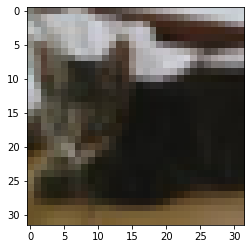

In [0]:
print(train_images_raw.shape)
print(train_labels_raw.shape)
print(test_images_raw.shape)
print(test_labels_raw.shape)
print(train_labels_raw[0])
plt.imshow(train_images_raw[9], cmap="Greys_r")
print(train_labels_raw[9])

In [0]:
train_data = tf.data.Dataset.from_tensor_slices(( train_images_raw.astype(np.float32)/255.0, train_labels_raw.astype(np.int32) ))

train_data = train_data.shuffle(buffer_size = train_images_raw.shape[0]).batch(512).repeat(2)

test_data = tf.data.Dataset.from_tensor_slices(( test_images_raw.astype(np.float32)/255.0, test_labels_raw.astype(np.int32) ))

test_data = test_data.batch(512)

In [0]:
input_shape = (train_images_raw.shape[1], train_images_raw.shape[2], train_images_raw.shape[3])
print(input_shape)

(32, 32, 3)


In [0]:
# Get the model.
inputs = keras.Input(shape = input_shape, name='cifar')
# x = layers.Conv2D(filters = 64, kernel_size=(1, 1), padding = "same", activation=tf.nn.relu, name = "conv_preprocess") (inputs)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding = "same", activation = tf.nn.relu, use_bias=True, kernel_initializer = initializers.he_normal(seed=0), bias_initializer = initializers.glorot_uniform(seed=0), name = "conv_1" ) (inputs)
# x = layers.AveragePooling2D(pool_size=(2,2)) (x)

# first denseblock block r1
x_0_saved = x

x_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding = "same", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_dens1a") (x)
x_1 = layers.BatchNormalization(name = 'r1a')(x_1)
x_1_saved = x_1

x_1 = tf.concat([x_0_saved, x_1], axis = -1, name = "concat1")

x_2 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding = "same", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_dens1b") (x_1)
x_2 = layers.BatchNormalization( name = 'r2a')(x_2)
x_2_saved = x_2

x_2 = tf.concat([x_0_saved, x_1_saved, x_2_saved], axis = -1, name = "concat2")

# 1st transition layer
transition_1 = layers.Conv2D(filters=24, kernel_size=(1, 1), strides=(2, 2), padding = "valid", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_trans1") (x_2)

# 2nd dense block
x_3 = layers.Conv2D(filters=16, kernel_size=(3, 3), padding = "same", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_dens2a") (transition_1)
x_3 = layers.BatchNormalization( name = 'r3a')(x_3)
x_3_saved = x_3

x_3 = tf.concat([x_3, transition_1], axis = -1, name = "concat3")

x_4 = layers.Conv2D(filters=16, kernel_size=(3, 3), padding = "same", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_dens2b") (x_3)
x_4 = layers.BatchNormalization( name = 'r4a')(x_4)
x_4_saved = x_4

x_4 = tf.concat([transition_1, x_3_saved, x_4_saved], axis = -1, name = "concat4")

# 2nd transition layer and dimensionality reducer
transition_2 = layers.Conv2D(filters=16, kernel_size=(1, 1), strides=(2, 2), padding = "valid", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_trans2") (x_4)


# 3rd dense block
x_5 = layers.Conv2D(filters=16, kernel_size=(3, 3), padding = "same", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_dens3a") (transition_2)
x_5 = layers.BatchNormalization( name = 'r5a')(x_5)
x_5_saved = x_5

x_5 = tf.concat([x_5, transition_2], axis = -1, name = "concat5")

x_6 = layers.Conv2D(filters=16, kernel_size=(3, 3), padding = "same", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_dens3b") (x_5)
x_6 = layers.BatchNormalization( name = 'r6a')(x_6)
x_6_saved = x_6

x_6 = tf.concat([transition_2, x_5_saved, x_6_saved], axis = -1, name = "concat6")

# 3rd transition layer and dimensionality reducer
transition_3 = layers.Conv2D(filters=12, kernel_size=(1, 1), strides=(2, 2), padding = "valid", activation = tf.nn.relu, use_bias=True, kernel_initializer= initializers.he_normal(seed=0), bias_initializer= initializers.glorot_uniform(seed=0), name = "conv_trans2") (x_6)


# flattening the tensor and connect it to a fully connected layer
x_reduce_dim = layers.Flatten() (transition_2)
x_dense_1 = layers.Dense(128, activation='relu', name='dense_1')(x_reduce_dim)
outputs = layers.Dense(10, name='predictions', activation='softmax')(x_dense_1)


model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 64)   1792        cifar[0][0]                      
__________________________________________________________________________________________________
conv_dens1a (Conv2D)            (None, 32, 32, 32)   18464       conv_1[0][0]                     
__________________________________________________________________________________________________
r1a (BatchNormalization)        (None, 32, 32, 32)   128         conv_dens1a[0][0]                
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [0]:
train_features = train_images_raw.astype(np.float32)/255.0 
test_features = test_images_raw.astype(np.float32)/255.0 

train_labels = convert_to_one_hot(train_labels_raw, 10).T
test_labels = convert_to_one_hot(test_labels_raw, 10).T
print(np.shape(train_labels))
print(np.shape(train_features))
print(train_labels[0:3,:])
print(train_features[0:1,:])

(50000, 10)
(50000, 32, 32, 3)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[[[0.23137255 0.24313726 0.24705882]
   [0.16862746 0.18039216 0.1764706 ]
   [0.19607843 0.1882353  0.16862746]
   ...
   [0.61960787 0.5176471  0.42352942]
   [0.59607846 0.49019608 0.4       ]
   [0.5803922  0.4862745  0.40392157]]

  [[0.0627451  0.07843138 0.07843138]
   [0.         0.         0.        ]
   [0.07058824 0.03137255 0.        ]
   ...
   [0.48235294 0.34509805 0.21568628]
   [0.46666667 0.3254902  0.19607843]
   [0.47843137 0.34117648 0.22352941]]

  [[0.09803922 0.09411765 0.08235294]
   [0.0627451  0.02745098 0.        ]
   [0.19215687 0.10588235 0.03137255]
   ...
   [0.4627451  0.32941177 0.19607843]
   [0.47058824 0.32941177 0.19607843]
   [0.42745098 0.28627452 0.16470589]]

  ...

  [[0.8156863  0.6666667  0.3764706 ]
   [0.7882353  0.6        0.13333334]
   [0.7764706  0.6313726  0.10196079]
   ...
   [0.627451   0.52156866 0.27

In [0]:
model.fit(train_features, train_labels, epochs = 10, batch_size = 64)

Epoch 1/10
782/782 [==============================] - 21s 27ms/step - loss: 1.4775 - accuracy: 0.4609
Epoch 2/10
782/782 [==============================] - 21s 27ms/step - loss: 1.1021 - accuracy: 0.6058
Epoch 3/10
782/782 [==============================] - 21s 27ms/step - loss: 0.9291 - accuracy: 0.6690
Epoch 4/10
782/782 [==============================] - 21s 27ms/step - loss: 0.8081 - accuracy: 0.7118
Epoch 5/10
782/782 [==============================] - 21s 27ms/step - loss: 0.7214 - accuracy: 0.7442
Epoch 6/10
782/782 [==============================] - 21s 27ms/step - loss: 0.6440 - accuracy: 0.7716
Epoch 7/10
782/782 [==============================] - 21s 27ms/step - loss: 0.5753 - accuracy: 0.7948
Epoch 8/10
782/782 [==============================] - 21s 27ms/step - loss: 0.5112 - accuracy: 0.8181
Epoch 9/10
782/782 [==============================] - 21s 27ms/step - loss: 0.4518 - accuracy: 0.8375
Epoch 10/10
782/782 [==============================] - 21s 27ms/step - loss: 0.398

In [0]:

preds = model.evaluate(test_features, test_labels)
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))


313/313 [==============================] - 2s 7ms/step - loss: 1.0752 - accuracy: 0.6846
Loss = 1.075183629989624
Test Accuracy = 0.6845999956130981


# **Flexible Dense Network using functions with hyperparameters such as growthrate, bottleneck and compression**

**Config 1:** growth rate = 5, compression = 0.5, dense blocks = 3, filters used inside dense blocks = 16, epochs = 10, **bottleneck layer = False**

- Test accuracy: 85.22%

**Config 2:** growth rate = 5, compression = 0.5, dense blocks = 3, filters used inside dense blocks = 16, epochs = 10, **bottleneck layer = True**, **bottle neck layer filters = 32**

- Test accuracy = 87%

We conclude that using** bottleneck incrweases parameter efficiency** and also increases accuracy a bit


In [0]:
def dense_block(growth_rate, filter_size, inputs, bottleneck = False, bottleneck_channels = 16, dense_block_num = 1, kernel_size = (3,3) ):
  alfabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k"]
  gr = [x for x in range(1, growth_rate+1)]
  temp = inputs

  if not bottleneck:
    for a, i in list(zip(alfabets, gr)):
      conv_layer_name = "conv_" + str(dense_block_num) + a
      batchnorm_layer_name = "bn_" + str(dense_block_num) + a
      concat_layer_name = "concat_" + str(dense_block_num) + a

      batchnorm = layers.BatchNormalization( name = batchnorm_layer_name)(temp)
      relu = layers.Activation('relu')(batchnorm)
      x = layers.Conv2D(filters=filter_size , kernel_size=kernel_size, padding = "same", name = conv_layer_name) (relu)
      #print(x.shape)
      
      concat = tf.concat([x, temp], axis = -1, name = concat_layer_name) 
      #print(concat.shape)
      temp = concat
      #print(conv_layer_name + " : " + batchnorm_layer_name + " : " + concat_layer_name)
      #print()
  elif bottleneck:
    for a, i in list(zip(alfabets, gr)):
      bottleneck_layer_name = "bottleneck_" + str(dense_block_num) + a
      conv_layer_name = "conv_" + str(dense_block_num) + a
      batchnorm_layer_name = "bn_" + str(dense_block_num) + a
      concat_layer_name = "concat_" + str(dense_block_num) + a

      batchnorm1 = layers.BatchNormalization( name = batchnorm_layer_name + "_1")(temp)
      relu1 = layers.Activation('relu')(batchnorm1)
      botneck = layers.Conv2D(filters = bottleneck_channels, kernel_size = (1, 1), padding = "same", name = bottleneck_layer_name) (relu1)

      batchnorm2 = layers.BatchNormalization( name = batchnorm_layer_name + "_2")(botneck)
      relu2 = layers.Activation('relu')(batchnorm2)
      x = layers.Conv2D(filters=filter_size , kernel_size=kernel_size, padding = "same", name = conv_layer_name) (relu2)
      #print(x.shape)
      
      concat = tf.concat([x, temp], axis = -1, name = concat_layer_name) 
      #print(concat.shape)
      temp = concat
      #print(conv_layer_name + " : " + batchnorm_layer_name + " : " + concat_layer_name)
      #print()

  return temp

In [0]:
def transition_block(inputs, filter_size, transition_layer_num = 1, compression = 0.5):
  transition_layer_name = str(transition_layer_num)

  batchnorm = layers.BatchNormalization( name = "bn_tr_" + transition_layer_name)(inputs)  
  relu = layers.Activation('relu')(batchnorm)
  
  conv_1_1 = layers.Conv2D(filters = filter_size * compression, kernel_size=(1, 1), padding = "same", name = "conv_tr" + transition_layer_name) (relu)
  avg_pool = layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2)) (conv_1_1)

  return avg_pool
  ;

In [0]:
def output_block(inputs, num_classes=10, dense_size = 32, pool_size = (2, 2)):
  # flattening the tensor and connect it to a fully connected layer
  BatchNorm = layers.BatchNormalization()(inputs)
  relu = layers.Activation('relu')(BatchNorm)
  avg_pool = layers.AveragePooling2D(pool_size = (2, 2)) (relu)
  conv_2d_2_2 = layers.Conv2D(num_classes, kernel_size = (2,2))(avg_pool) 
  x_reduce_dim = layers.Flatten() (conv_2d_2_2)
  x_dense_1 = layers.Dense(dense_size, activation='relu', name='dense_1')(x_reduce_dim)
  outputs = layers.Dense(10, name='predictions', activation='softmax')(x_dense_1)
  return outputs;


In [0]:
inputs = keras.Input(shape = (32, 32, 3), name='cifar')
model = dense_block(compression = 0.5, growth_rate = 4, filter_size = 12, inputs = inputs)

TypeError: ignored

In [0]:
def densenet_model(input_shape, compression, growth_rate, bottleneck = False, bottleneck_channels = 16):
  inputs = keras.Input(shape = input_shape, name='cifar')
  conv_preprocess = layers.Conv2D(filters=36, kernel_size=(3, 3), strides=(1, 1), padding = "same", use_bias=True, kernel_initializer = initializers.he_normal(seed=0), bias_initializer = initializers.glorot_uniform(seed=0), name = "conv_preprocess" ) (inputs)
  
  d1 = dense_block(growth_rate = growth_rate, filter_size = 16, inputs = conv_preprocess, dense_block_num = 1, kernel_size = (3,3), bottleneck = bottleneck, bottleneck_channels = bottleneck_channels) 
  t1_filter_size = d1.shape[3]
  t1 = transition_block(inputs = d1, filter_size = t1_filter_size, transition_layer_num = 1, compression = compression)
  
  d2 = dense_block(growth_rate = growth_rate, filter_size = 16, inputs = t1, dense_block_num = 2, kernel_size = (3,3), bottleneck = bottleneck, bottleneck_channels = bottleneck_channels) 
  t2_filter_size = d2.shape[3]
  t2 = transition_block(inputs = d2, filter_size = t2_filter_size, transition_layer_num = 2, compression = compression)

  d3 = dense_block(growth_rate = growth_rate, filter_size = 16, inputs = t2, dense_block_num = 3, kernel_size = (3,3), bottleneck = bottleneck, bottleneck_channels = bottleneck_channels)
  #t3_filter_size = d3.shape[3]
  #t3 = transition_block(inputs = d3, filter_size = t3_filter_size, transition_layer_num = 3, compression = compression)
  
  output_tensor = output_block(inputs = d3, dense_size = 32, pool_size = (2, 2))

  model = keras.Model(inputs=inputs, outputs=output_tensor)
  model.summary()
  return model;
  

In [0]:
model_config1 = densenet_model(input_shape = (32, 32, 3), compression = 0.5, growth_rate = 5, bottleneck = False, bottleneck_channels = 16)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a (BatchNormalization)      (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 36)   0           bn_1a[0][0]                      
______________________________________________________________________________________________

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
batch_size = 128
num_classes = 10
epochs = 250
l = 5
num_filter = 36
compression = 0.5

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
print("training samples shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)
print("test samples shape: ", x_test.shape)
print("test labels shape: ", y_test.shape)

training samples shape:  (50000, 32, 32, 3)
training labels shape:  (50000, 10)
test samples shape:  (10000, 32, 32, 3)
test labels shape:  (10000, 10)


In [0]:
datagen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15)
datagen.fit(x_train)

In [0]:
model_config1.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [0]:
model_config1.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 10 ,validation_data =(x_test, y_test))

Epoch 1/10
1172/1171 [==============================] - 170s 145ms/step - loss: 1.2344 - accuracy: 0.5564 - val_loss: 0.9338 - val_accuracy: 0.6767
Epoch 2/10
1172/1171 [==============================] - 169s 144ms/step - loss: 0.8160 - accuracy: 0.7121 - val_loss: 0.7852 - val_accuracy: 0.7360
Epoch 3/10
1172/1171 [==============================] - 169s 144ms/step - loss: 0.6694 - accuracy: 0.7648 - val_loss: 0.6522 - val_accuracy: 0.7865
Epoch 4/10
1172/1171 [==============================] - 169s 144ms/step - loss: 0.5856 - accuracy: 0.7956 - val_loss: 0.6601 - val_accuracy: 0.7833
Epoch 5/10
1172/1171 [==============================] - 169s 144ms/step - loss: 0.5290 - accuracy: 0.8166 - val_loss: 0.6436 - val_accuracy: 0.7842
Epoch 6/10
1172/1171 [==============================] - 168s 144ms/step - loss: 0.4875 - accuracy: 0.8308 - val_loss: 0.5667 - val_accuracy: 0.8128
Epoch 7/10
1172/1171 [==============================] - 169s 144ms/step - loss: 0.4553 - accuracy: 0.8412 - val_

Config 1 produced 86.5% train accuracy and 85.2% test accuracy

In [0]:
model_config2 = densenet_model(input_shape = (32, 32, 3), compression = 0.5, growth_rate = 5, bottleneck = True, bottleneck_channels = 32)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a (BatchNormalization)      (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 32, 32, 36)   0           bn_1a[0][0]                      
____________________________________________________________________________________________

In [0]:
model_config2.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015), metrics=['accuracy'])

In [0]:
model_config2.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 20 ,validation_data =(x_test, y_test))

Epoch 1/20
1172/1171 [==============================] - 84s 71ms/step - loss: 1.2223 - accuracy: 0.5601 - val_loss: 1.0417 - val_accuracy: 0.6497
Epoch 2/20
1172/1171 [==============================] - 83s 71ms/step - loss: 0.8282 - accuracy: 0.7081 - val_loss: 0.9370 - val_accuracy: 0.6925
Epoch 3/20
1172/1171 [==============================] - 84s 72ms/step - loss: 0.6884 - accuracy: 0.7594 - val_loss: 0.6775 - val_accuracy: 0.7661
Epoch 4/20
1172/1171 [==============================] - 83s 71ms/step - loss: 0.6089 - accuracy: 0.7887 - val_loss: 0.6380 - val_accuracy: 0.7904
Epoch 5/20
1172/1171 [==============================] - 83s 71ms/step - loss: 0.5545 - accuracy: 0.8067 - val_loss: 0.7158 - val_accuracy: 0.7721
Epoch 6/20
1172/1171 [==============================] - 84s 72ms/step - loss: 0.5146 - accuracy: 0.8213 - val_loss: 0.7270 - val_accuracy: 0.7670
Epoch 7/20
1172/1171 [==============================] - 85s 72ms/step - loss: 0.4824 - accuracy: 0.8326 - val_loss: 0.6759 -

Config 2 : With bottleneck of 32 channels at bottleneck and growth rate of 5 clocked highest of 87% validation error for 20 epochs and 83% validation error for 10 epochs

# **Playing with growth rate**
**Summary**: Earlier we saw densenets with growth rate of fixed 5. Now we will change the growth rate to 3, 7, 9 and 12 and run for 10 - 20 epochs(epochs are kept a little less as gpu availability need to be considered).
As expected , increase in growth rate leads to increase in accuracy as more and more featuremaps are considered inside the dense block

**growth rate = 3 | config 4:** 
Params used = 80K, time taken to train per epoch = 80 seconds, 
Training accuracy = 86%, Test accuracy = 84%

**growth rate = 7 | config 3:**
Params used = 230K, time taken to train per epoch = 100 seconds, 
Training accuracy = 90%, Test accuracy = 88%

**growth rate = 9 | config 5:**
Params used = 330K, time taken to train per epoch = 120 seconds, 
Training accuracy = 93%, Test accuracy = 90%


**growth rate = 12 | config 6:** 
Params used = 450K, time taken to train per epoch = 150 seconds, 
Training accuracy = 94%, Test accuracy = 90%



In [0]:

model_config3 = densenet_model(input_shape = (32, 32, 3), compression = 0.5, growth_rate = 7, bottleneck = True, bottleneck_channels = 32)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a_1 (BatchNormalization)    (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation_126 (Activation)     (None, 32, 32, 36)   0           bn_1a_1[0][0]                    
____________________________________________________________________________________________

In [0]:
model_config3.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015), metrics=['accuracy'])

In [0]:
model_config3.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 20 ,validation_data =(x_test, y_test))

Epoch 1/20
1172/1171 [==============================] - 104s 89ms/step - loss: 1.2087 - accuracy: 0.5643 - val_loss: 1.2387 - val_accuracy: 0.5924
Epoch 2/20
1172/1171 [==============================] - 101s 86ms/step - loss: 0.7793 - accuracy: 0.7254 - val_loss: 0.8017 - val_accuracy: 0.7307
Epoch 3/20
1172/1171 [==============================] - 99s 84ms/step - loss: 0.6371 - accuracy: 0.7775 - val_loss: 0.6748 - val_accuracy: 0.7796
Epoch 4/20
1172/1171 [==============================] - 97s 83ms/step - loss: 0.5478 - accuracy: 0.8092 - val_loss: 0.7885 - val_accuracy: 0.7537
Epoch 5/20
1172/1171 [==============================] - 97s 83ms/step - loss: 0.4912 - accuracy: 0.8292 - val_loss: 0.5316 - val_accuracy: 0.8252
Epoch 6/20
1172/1171 [==============================] - 97s 83ms/step - loss: 0.4466 - accuracy: 0.8449 - val_loss: 0.4959 - val_accuracy: 0.8380
Epoch 7/20
1172/1171 [==============================] - 98s 84ms/step - loss: 0.4157 - accuracy: 0.8566 - val_loss: 1.0015

In [0]:
model_config4 = densenet_model(input_shape = (32, 32, 3), compression = 0.5, growth_rate = 3, bottleneck = True, bottleneck_channels = 32)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a_1 (BatchNormalization)    (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation_171 (Activation)     (None, 32, 32, 36)   0           bn_1a_1[0][0]                    
____________________________________________________________________________________________

In [0]:
model_config4.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015), metrics=['accuracy'])

In [0]:
model_config4.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 20 ,validation_data =(x_test, y_test))

Epoch 1/20
1172/1171 [==============================] - 77s 65ms/step - loss: 1.2916 - accuracy: 0.5351 - val_loss: 1.0468 - val_accuracy: 0.6238
Epoch 2/20
1172/1171 [==============================] - 76s 65ms/step - loss: 0.9062 - accuracy: 0.6777 - val_loss: 1.0659 - val_accuracy: 0.6499
Epoch 3/20
1172/1171 [==============================] - 77s 66ms/step - loss: 0.7792 - accuracy: 0.7260 - val_loss: 0.7902 - val_accuracy: 0.7310
Epoch 4/20
1172/1171 [==============================] - 77s 66ms/step - loss: 0.7016 - accuracy: 0.7539 - val_loss: 0.8022 - val_accuracy: 0.7358
Epoch 5/20
1172/1171 [==============================] - 77s 66ms/step - loss: 0.6510 - accuracy: 0.7728 - val_loss: 0.7260 - val_accuracy: 0.7649
Epoch 6/20
1172/1171 [==============================] - 77s 66ms/step - loss: 0.6089 - accuracy: 0.7880 - val_loss: 0.7385 - val_accuracy: 0.7535
Epoch 7/20
1172/1171 [==============================] - 77s 66ms/step - loss: 0.5750 - accuracy: 0.7997 - val_loss: 0.6859 -

In [0]:
model_config5 = densenet_model(input_shape = (32, 32, 3), compression = 0.5, growth_rate = 9, bottleneck = True, bottleneck_channels = 32)
model_config5.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), metrics=['accuracy'])
model_config5.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 20 ,validation_data =(x_test, y_test))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a_1 (BatchNormalization)    (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation_192 (Activation)     (None, 32, 32, 36)   0           bn_1a_1[0][0]                    
____________________________________________________________________________________________

In [0]:
model_config6 = densenet_model(input_shape = (32, 32, 3), compression = 0.5, growth_rate = 12, bottleneck = True, bottleneck_channels = 32)
model_config6.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0025), metrics=['accuracy'])
model_config6.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 20 ,validation_data =(x_test, y_test))

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a_1 (BatchNormalization)    (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation_249 (Activation)     (None, 32, 32, 36)   0           bn_1a_1[0][0]                    
____________________________________________________________________________________________

# **Playing with compression**
**Summary**: We have fixed growth rate to 5 and experiment with high(0.2), medium(0.5) and low compression(0.9). We recorded the accuracy , number of parameters and training time per epoch.  We ran experiments for 10-20 epochs

As expected if we use more compression, the parameters would decrease and training time also decreased meagerly. But accuracy actually remained same for compression = 0.2 when compared to 0.5 which was a surprise, maybe there were more redundancy in featuremaps that could be removed without affecting overall outcome. As expected for low compression(0.9) we got 87% accuracy.

**compression = 0.2 | config 7:** 
Params used = 120K, time taken to train per epoch = 83 seconds, 
Training accuracy = 88%, Test accuracy = 86.5%

**compression = 0.5 | config 2:** 
Params used = 150K, time taken to train per epoch = 85 seconds, 
Training accuracy = 89%, Test accuracy = 87.2%

**compression = 0.9 | config 8:** 
Params used = 200K, time taken to train per epoch = 90 seconds, 
Training accuracy = 91%, Test accuracy = 87%


In [0]:
model_config7 = densenet_model(input_shape = (32, 32, 3), compression = 0.2, growth_rate = 5, bottleneck = True, bottleneck_channels = 32)
model_config7.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), metrics=['accuracy'])
model_config7.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 20 ,validation_data =(x_test, y_test))

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a_1 (BatchNormalization)    (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation_318 (Activation)     (None, 32, 32, 36)   0           bn_1a_1[0][0]                    
____________________________________________________________________________________________

In [0]:
model_config8 = densenet_model(input_shape = (32, 32, 3), compression = 0.9, growth_rate = 5, bottleneck = True, bottleneck_channels = 32)
model_config8.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), metrics=['accuracy'])
model_config8.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
                    epochs = 20 ,validation_data =(x_test, y_test))

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cifar (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_preprocess (Conv2D)        (None, 32, 32, 36)   1008        cifar[0][0]                      
__________________________________________________________________________________________________
bn_1a_1 (BatchNormalization)    (None, 32, 32, 36)   144         conv_preprocess[0][0]            
__________________________________________________________________________________________________
activation_351 (Activation)     (None, 32, 32, 36)   0           bn_1a_1[0][0]                    
____________________________________________________________________________________________

# **Using tf.function and recording run time**

**Conclusion:** with tf.function computation was a bit faster than regular function for my other teammate. For me, with tf.function it took approximately 10.5 seconds per epoch where as with out tf.function it took approximately 10.5 seconds per epoch. Hence i did not see any particular decrease in runtime, which could be due to numerous factors like availability of compute resources on colab.



Using tf.function on cifar-10

[4]


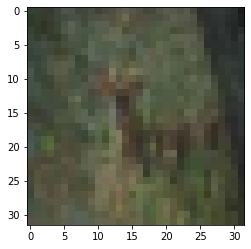

In [28]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
print(train_labels[10])
plt.imshow(train_images[10], cmap=plt.cm.binary)

In [0]:
train_data = tf.data.Dataset.from_tensor_slices(( train_images.astype(np.float32)/255.0, train_labels.astype(np.int32) ))

train_data = train_data.shuffle(buffer_size = train_images.shape[0]).batch(256)

test_data = tf.data.Dataset.from_tensor_slices(( test_images.astype(np.float32)/255.0, test_labels.astype(np.int32) ))

test_data = test_data.batch(256)

In [0]:
model = models.Sequential([layers.Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer= "he_uniform",input_shape=(32,32,3)),
                          layers.BatchNormalization(),
                          layers.Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer= "he_uniform"),
                          layers.BatchNormalization(), 
                          layers.MaxPooling2D(),
                          layers.Dropout(0.3),
                           
                          layers.Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer= "he_uniform"),
                          layers.BatchNormalization(),
                          layers.Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer= "he_uniform"),
                          layers.BatchNormalization(), 
                          layers.MaxPooling2D(),
                          layers.Dropout(0.4),

                          layers.Conv2D(256,(3,3),activation='relu',padding='same',kernel_initializer= "he_uniform"),
                          layers.BatchNormalization(),
                          layers.Conv2D(256,(3,3),activation='relu',padding='same',kernel_initializer= "he_uniform"),
                          layers.BatchNormalization(), 
                          layers.MaxPooling2D(),
                          layers.Dropout(0.5), 
                           
                          layers.Flatten(), 
                          layers.Dense(64, activation='relu'), 
                          layers.Dense(10) ])

In [0]:
optimizer = keras.optimizers.Adam(learning_rate=  5 * 1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [0]:
# @tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = model(imgs)
        xent = loss_fn(lbls, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
    optimizer.apply_gradients(zip(grads, varis))

    return xent, logits

In [15]:
start = time.time()
epochs=21
for epoch in range(epochs):
  tf.print("===== epoch number: {}".format(epoch))

  start_epoch = time.time()
  for step, (x_batch_train, y_batch_train) in enumerate(train_data):
    xent, logits = train_step(x_batch_train, y_batch_train)
    train_acc_metric(y_batch_train, logits)

  train_acc = train_acc_metric.result()
  tf.print('Training acc over epoch: %s' % (float(train_acc),))
  train_acc_metric.reset_states()

  for x_batch_val, y_batch_val in test_data:
    val_logits = model(x_batch_val)
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  tf.print('Validation acc: %s' % (float(val_acc),))
  end_epoch = time.time()
  tf.print("time taken for this epoch(in seconds): ",(end_epoch - start_epoch))
stop = time.time()
tf.print("total time(in second): ", (stop - start))

===== epoch number: 0
Training acc over epoch: 0.29030001163482666
Validation acc: 0.41440001130104065
time taken for this epoch(in seconds):  17.0796959400177
===== epoch number: 1
Training acc over epoch: 0.4498000144958496
Validation acc: 0.4661000072956085
time taken for this epoch(in seconds):  10.78994369506836
===== epoch number: 2
Training acc over epoch: 0.5226399898529053
Validation acc: 0.5393999814987183
time taken for this epoch(in seconds):  10.54870319366455
===== epoch number: 3
Training acc over epoch: 0.5794000029563904
Validation acc: 0.5791000127792358
time taken for this epoch(in seconds):  10.579259395599365
===== epoch number: 4
Training acc over epoch: 0.6185399889945984
Validation acc: 0.6139000058174133
time taken for this epoch(in seconds):  10.570479393005371
===== epoch number: 5
Training acc over epoch: 0.654259979724884
Validation acc: 0.6509000062942505
time taken for this epoch(in seconds):  10.598912239074707
===== epoch number: 6
Training acc over epo

In [22]:
for img_batch, lbl_batch in test_data:
    val_acc_metric(lbl_batch, model(img_batch))

val_acc_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0965>

**Without tf.function**

In [32]:
start = time.time()
epochs=11
for epoch in range(epochs):
  print("===== epoch number: {}".format(epoch))

  start_epoch = time.time()
  for step, (x_batch_train, y_batch_train) in enumerate(train_data):
    with tf.GradientTape() as tape:
        logits = model(x_batch_train)
        xent = loss_fn(y_batch_train, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
    optimizer.apply_gradients(zip(grads, varis))
    #xent, logits = train_step(x_batch_train, y_batch_train)
    train_acc_metric(y_batch_train, logits)

  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))
  train_acc_metric.reset_states()

  for x_batch_val, y_batch_val in test_data:
    val_logits = model(x_batch_val)
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  print('Validation acc: %s' % (float(val_acc),))
  end_epoch = time.time()
  print("time taken for this epoch(in seconds): ",(end_epoch - start_epoch))
stop = time.time()
print("total time(in second): ", (stop - start))

===== epoch number: 0
Training acc over epoch: 0.10809999704360962
Validation acc: 0.10000000149011612
time taken for this epoch(in seconds):  10.450707912445068
===== epoch number: 1
Training acc over epoch: 0.09749999642372131
Validation acc: 0.10000000149011612
time taken for this epoch(in seconds):  10.398381233215332
===== epoch number: 2
Training acc over epoch: 0.09765999764204025
Validation acc: 0.10000000149011612
time taken for this epoch(in seconds):  10.418264150619507
===== epoch number: 3
Training acc over epoch: 0.09976000338792801
Validation acc: 0.10000000149011612
time taken for this epoch(in seconds):  10.35786771774292
===== epoch number: 4
Training acc over epoch: 0.09861999750137329
Validation acc: 0.10000000149011612
time taken for this epoch(in seconds):  10.337143182754517
===== epoch number: 5
Training acc over epoch: 0.09905999898910522
Validation acc: 0.10000000149011612
time taken for this epoch(in seconds):  10.325779914855957
===== epoch number: 6
Trainin

# **Using computation graph**

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
img_rows, img_cols = 28, 28

# the data, split between train and test set

if K.image_data_format() == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
    test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
    test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [0]:
train_data = tf.data.Dataset.from_tensor_slices(( train_images.astype(np.float32)/255.0, train_labels.astype(np.int32) ))

train_data = train_data.shuffle(buffer_size = train_images.shape[0]).batch(32)

test_data = tf.data.Dataset.from_tensor_slices(( test_images.astype(np.float32)/255.0, test_labels.astype(np.int32) ))

test_data = test_data.batch(32)

In [0]:
model = keras.Sequential([layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=input_shape),
                          layers.MaxPool2D(),
                          layers.Conv2D(64,(3,3),activation='relu',padding='same'),
                          layers.MaxPool2D(), 
                          layers.Flatten(), 
                          layers.Dense(64, activation='relu'), 
                          layers.Dense(10) ])

In [0]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=  5 * 1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [0]:
@tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = model(imgs)
        xent = loss_fn(lbls, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
    optimizer.apply_gradients(zip(grads, varis))

    return xent, logits
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

In [39]:
epochs=5
for epoch in range(epochs):
  print("===== epoch number: {}".format(epoch))
  for step, (x_batch_train, y_batch_train) in enumerate(train_data):
    tf.summary.trace_on(graph=True, profiler=True)
    xent, logits = train_step(x_batch_train, y_batch_train)
    with writer.as_default():
      tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)
    train_acc_metric(y_batch_train, logits)

  train_acc = train_acc_metric.result()
  tf.print('Training acc over epoch: %s' % (float(train_acc),))
  train_acc_metric.reset_states()

  for x_batch_val, y_batch_val in test_data:
    val_logits = model(x_batch_val)
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  tf.print('Validation acc: %s' % (float(val_acc),))

===== epoch number: 0
Training acc over epoch: 0.9653000235557556
Validation acc: 0.9843999743461609
===== epoch number: 1
Training acc over epoch: 0.9843666553497314
Validation acc: 0.9843999743461609
===== epoch number: 2
Training acc over epoch: 0.9874666929244995
Validation acc: 0.9854999780654907
===== epoch number: 3
Training acc over epoch: 0.9894999861717224
Validation acc: 0.9868000149726868
===== epoch number: 4
Training acc over epoch: 0.9914500117301941
Validation acc: 0.9829999804496765
